### LoRA Based Fine-Tuning of Qwen 2.5 for Time-Series Forecasting 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import random
import h5py
import pandas as pd
import time
import importlib
from pprint import pprint
import torch 

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [4]:
file_path = "data/lotka_volterra_data.h5"  # Change this to the correct path

In [5]:
with h5py.File(file_path, "r") as f:
    # Print the dataset keys
    print("Keys in HDF5 file:", list(f.keys()))
    time_data, traj_data = f[list(f.keys())[0]][:], f[list(f.keys())[-1]][:]

Keys in HDF5 file: ['time', 'trajectories']


##### Need to find which axes are of prey (0) and predator (1)

In [6]:
data_prey, data_pred = traj_data[:, :, 0], traj_data[:, :, -1]
print(time_data.shape, data_prey.shape, data_pred.shape)

(100,) (1000, 100) (1000, 100)


#### Evolution

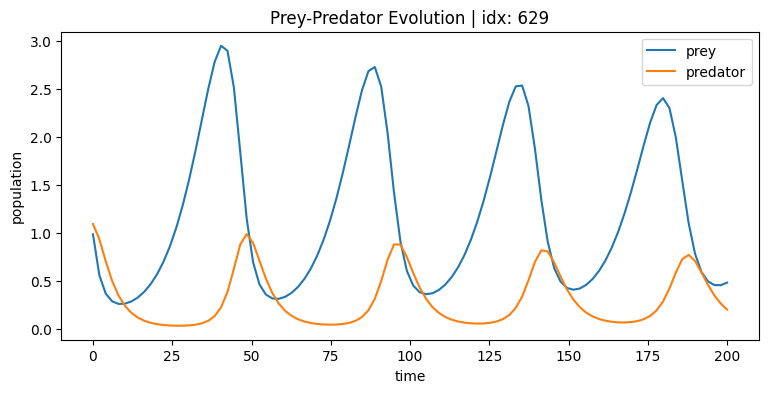

In [7]:
rn = random.randint(0, len(data_prey))

fig = plt.figure(figsize=(9, 4))

plt.plot(time_data, data_prey[rn], label = 'prey')
plt.plot(time_data, data_pred[rn], label = 'predator')
plt.xlabel('time')
plt.ylabel('population')

plt.legend()
plt.title(f'Prey-Predator Evolution | idx: {rn}')
plt.show()

#### Qwen 2.5 (Untrained) - Zero Shot Forecasting

Qwen's Interfacing

```
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

```

In [8]:
from utils.qwen import load_qwen

ft = time.time()
model, tokenizer = load_qwen()
lt = time.time()

print('time-taken: ', (lt - ft)/60, 'mins') 

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


time-taken:  0.15628577868143717 mins


In [9]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

##### LLMTIME preprocessing scheme (tokenize time-series data for Qwen instruct model)

In [59]:
import utils.preprocess
importlib.reload(utils.preprocess)
from utils.preprocess import ts_encoding, ts_decoding

In [60]:
check_rn = random.randint(0, len(data_prey))

In [61]:
tokenized_prey, offset_prey, scale_prey = ts_encoding(data_prey[check_rn], model_type="gpt", precision=3, alpha=0.99, beta=0.3)
tokenized_pred, offset_prey, scale_prey = ts_encoding(data_pred[check_rn], model_type="gpt", precision=3, alpha=0.99, beta=0.3)

# print(tokenized_prey.shape, tokenized_pred.shape)
print('----------GPT-Encoding-------------')
print('Input: ', data_prey)
print('Tokenized: ', tokenized_prey)

print()
print()

tokenized_prey, offset_prey, scale_prey = ts_encoding(data_prey[check_rn], model_type="llama", precision=3, alpha=0.99, beta=0.3)
tokenized_pred, offset_prey, scale_prey = ts_encoding(data_pred[check_rn], model_type="llama", precision=3, alpha=0.99, beta=0.3)

# print(tokenized_prey.shape, tokenized_pred.shape)
print('----------LLAMA-Encoding-------------')
print('Input: ', data_prey)
print('Tokenized: ', tokenized_prey)

Offset:  -0.41717726 Scale-Factor:  2.5428896
Offset:  -0.2418077 Scale-Factor:  1.2146714
----------GPT-Encoding-------------
Input:  [[0.94991744 0.74055135 0.6822457  ... 2.3228664  2.3574128  2.347119  ]
 [0.9714744  1.0787003  1.260828   ... 2.4988842  2.4662724  2.4367042 ]
 [1.0732226  0.8540631  0.7681343  ... 2.3229585  2.3230035  2.3240573 ]
 ...
 [1.1288372  1.025194   0.9859951  ... 0.48976815 0.6844779  0.9849731 ]
 [1.1316459  0.80084616 0.6483697  ... 0.70776564 0.7266514  0.7947279 ]
 [1.0202591  0.76560074 0.6272315  ... 1.0364599  1.1292115  1.2237015 ]]
Tokenized:  0 . 4 8 9, 0 . 3 4 3, 0 . 2 7 6, 0 . 2 4 8, 0 . 2 3 7, 0 . 2 3 5, 0 . 2 4 0, 0 . 2 5 0, 0 . 2 6 6, 0 . 2 8 8, 0 . 3 1 7, 0 . 3 5 6, 0 . 4 0 5, 0 . 4 6 8, 0 . 5 4 7, 0 . 6 4 1, 0 . 7 5 1, 0 . 8 6 9, 0 . 9 7 3, 1 . 0 1 9, 0 . 9 3 7, 0 . 7 1 4, 0 . 4 8 0, 0 . 3 4 1, 0 . 2 7 7, 0 . 2 5 0, 0 . 2 3 9, 0 . 2 3 8, 0 . 2 4 3, 0 . 2 5 4, 0 . 2 7 0, 0 . 2 9 3, 0 . 3 2 4, 0 . 3 6 4, 0 . 4 1 5, 0 . 4 8 0, 0 . 5 6 0, 0 

### Shouldn't we jointly train prey and predator population <-- Since they are correlated 

##### Seperated Inferencing
One way to combine is ``` prey_t, pred_t ; prey_t+1, pred_t+1 ...``` 

In [76]:
forecast_length = 50
max_tokens = 512

In [77]:
def create_forecast_prompt(encoded_series, forecast_length=10, name='prey'):
    prompt = f"""<|im_start|>user
    I have a time series representing {name} populations. Each timestep is separated by commas.

    Time series data: {encoded_series}

    Please predict the next {forecast_length} timesteps, maintaining the same pattern and formatting. Only provide the continuation without any explanation.
    <|im_end|>
    <|im_start|>assistant
    """
    return prompt

# Generate forecasts
def generate_forecast(encoded_series, forecast_length=10, max_new_tokens=100):

    prompt = create_forecast_prompt(encoded_series, forecast_length)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # Set parameters for more deterministic generation
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=0.1,  # Low temperature for more deterministic output
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    # Extract only the newly generated tokens
    generated_text = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return generated_text.strip()

In [78]:
prey_prompt = create_forecast_prompt(tokenized_prey, forecast_length=forecast_length, name='prey')
pprint(prey_prompt)
print()
print()
pred_prompt = create_forecast_prompt(tokenized_pred, forecast_length=forecast_length, name='predator')
pprint(pred_prompt)

('<|im_start|>user\n'
 '    I have a time series representing prey populations. Each timestep is '
 'separated by commas.\n'
 '\n'
 '    Time series data: 0.489, 0.343, 0.276, 0.248, 0.237, 0.235, 0.240, '
 '0.250, 0.266, 0.288, 0.317, 0.356, 0.405, 0.468, 0.547, 0.641, 0.751, 0.869, '
 '0.973, 1.019, 0.937, 0.714, 0.480, 0.341, 0.277, 0.250, 0.239, 0.238, 0.243, '
 '0.254, 0.270, 0.293, 0.324, 0.364, 0.415, 0.480, 0.560, 0.656, 0.766, 0.881, '
 '0.975, 1.000, 0.891, 0.662, 0.449, 0.329, 0.274, 0.250, 0.241, 0.241, 0.247, '
 '0.259, 0.277, 0.302, 0.335, 0.378, 0.432, 0.501, 0.584, 0.683, 0.794, 0.903, '
 '0.981, 0.971, 0.823, 0.590, 0.407, 0.311, 0.267, 0.249, 0.243, 0.245, 0.253, '
 '0.267, 0.288, 0.315, 0.351, 0.398, 0.458, 0.531, 0.620, 0.723, 0.832, 0.931, '
 '0.978, 0.914, 0.723, 0.505, 0.362, 0.292, 0.260, 0.248, 0.246, 0.251, 0.262, '
 '0.279, 0.302, 0.334, 0.375, 0.427\n'
 '\n'
 '    Please predict the next 50 timesteps, maintaining the same pattern and '
 'formatting. Only pro

In [ ]:
prey_response = generate_forecast(prey_prompt, forecast_length=forecast_length, max_new_tokens=max_tokens)
prey_decoded_response = ts_decoding(prey_response, model_type="gpt", precision=3, offset=offset_prey, scale_factor=scale_prey)[:forecast_length]

print(prey_decoded_response)
print('LEN: ', len(prey_decoded_response))

pred_response = generate_forecast(pred_prompt, forecast_length=forecast_length, max_new_tokens=max_tokens)
pred_decoded_response = ts_decoding(pred_response, model_type="gpt", precision=3, offset=offset_prey, scale_factor=scale_prey)[:forecast_length]

print(pred_decoded_response)
print('LEN: ', len(pred_decoded_response))

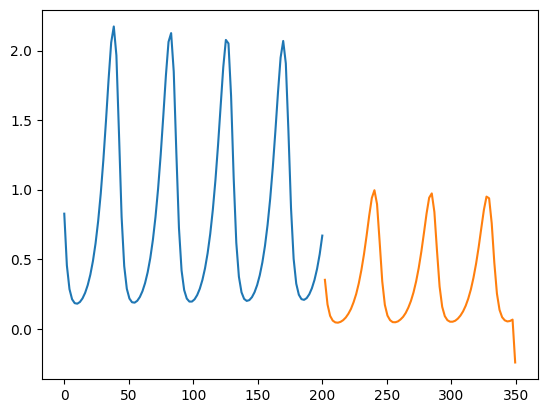

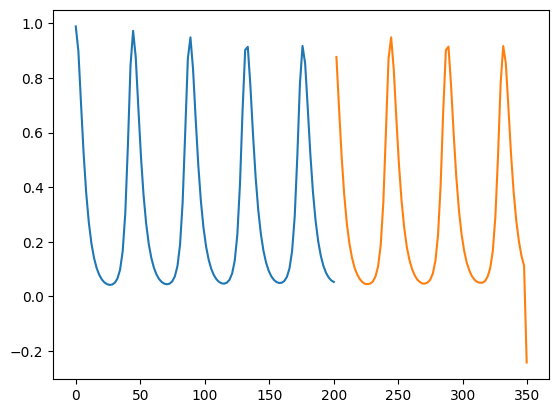

In [ ]:
diff = abs(time_data[0] - time_data[1])

time_test_data = []
tmp = time_data[-1]
for _ in range(len(prey_decoded_response)):
    tmp += diff
    time_test_data.append(tmp)

plt.plot(time_data, data_prey[check_rn].tolist())
plt.plot(time_test_data, prey_decoded_response)
plt.title('Prey-Population')
plt.xlabel('time')
plt.show()

print()

plt.plot(time_data, data_pred[check_rn].tolist())
plt.plot(time_test_data, pred_decoded_response)
plt.title('Predator-Population')
plt.xlabel('time')
plt.show()

array([  0.        ,   2.02020202,   4.04040404,   6.06060606,
         8.08080808,  10.1010101 ,  12.12121212,  14.14141414,
        16.16161616,  18.18181818,  20.2020202 ,  22.22222222,
        24.24242424,  26.26262626,  28.28282828,  30.3030303 ,
        32.32323232,  34.34343434,  36.36363636,  38.38383838,
        40.4040404 ,  42.42424242,  44.44444444,  46.46464646,
        48.48484848,  50.50505051,  52.52525253,  54.54545455,
        56.56565657,  58.58585859,  60.60606061,  62.62626263,
        64.64646465,  66.66666667,  68.68686869,  70.70707071,
        72.72727273,  74.74747475,  76.76767677,  78.78787879,
        80.80808081,  82.82828283,  84.84848485,  86.86868687,
        88.88888889,  90.90909091,  92.92929293,  94.94949495,
        96.96969697,  98.98989899, 101.01010101, 103.03030303,
       105.05050505, 107.07070707, 109.09090909, 111.11111111,
       113.13131313, 115.15151515, 117.17171717, 119.19191919,
       121.21212121, 123.23232323, 125.25252525, 127.27